In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 2
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.5     # perturbation
a                      = 0.98;   # parameter value corresponding to ϵ=0

In [4]:
T(x ,p) = [rem2pi(x[1] + x[2] + (a+p)*sin(x[1]), RoundDown),
           rem2pi(       x[2] + (a+p)*sin(x[1]), RoundDown)]

T (generic function with 1 method)

In [5]:
using Random

In [6]:
LL, UR = (0.0, 0.0), (2π, 2π)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order)
pred(x,y) = peuclidean(x, y, [2π, 2π]) < 1e-9
bdata = BoundaryData(ctx, pred);

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata);

  2.466009 seconds (13.17 M allocations: 561.434 MiB, 4.65% gc time)


In [9]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
if u₀[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]<0
    u₀ = -u₀
end
λ₀

  3.044475 seconds (9.51 M allocations: 553.607 MiB, 4.68% gc time)


-1.104418600678453

In [10]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata);

  2.496769 seconds (16.84 M allocations: 823.330 MiB, 6.34% gc time)


In [11]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.679970 seconds (2.45 M allocations: 141.374 MiB, 5.71% gc time)


-0.22434319174055029

In [12]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
if uϵ[Int(floor(0.5*grid_resolution*grid_resolution+0.25*grid_resolution))]<0
    uϵ = -uϵ
end
λϵ

-1.250805205353589

In [13]:
λ₀ + ϵ*λ_dot

-1.2165901965487282

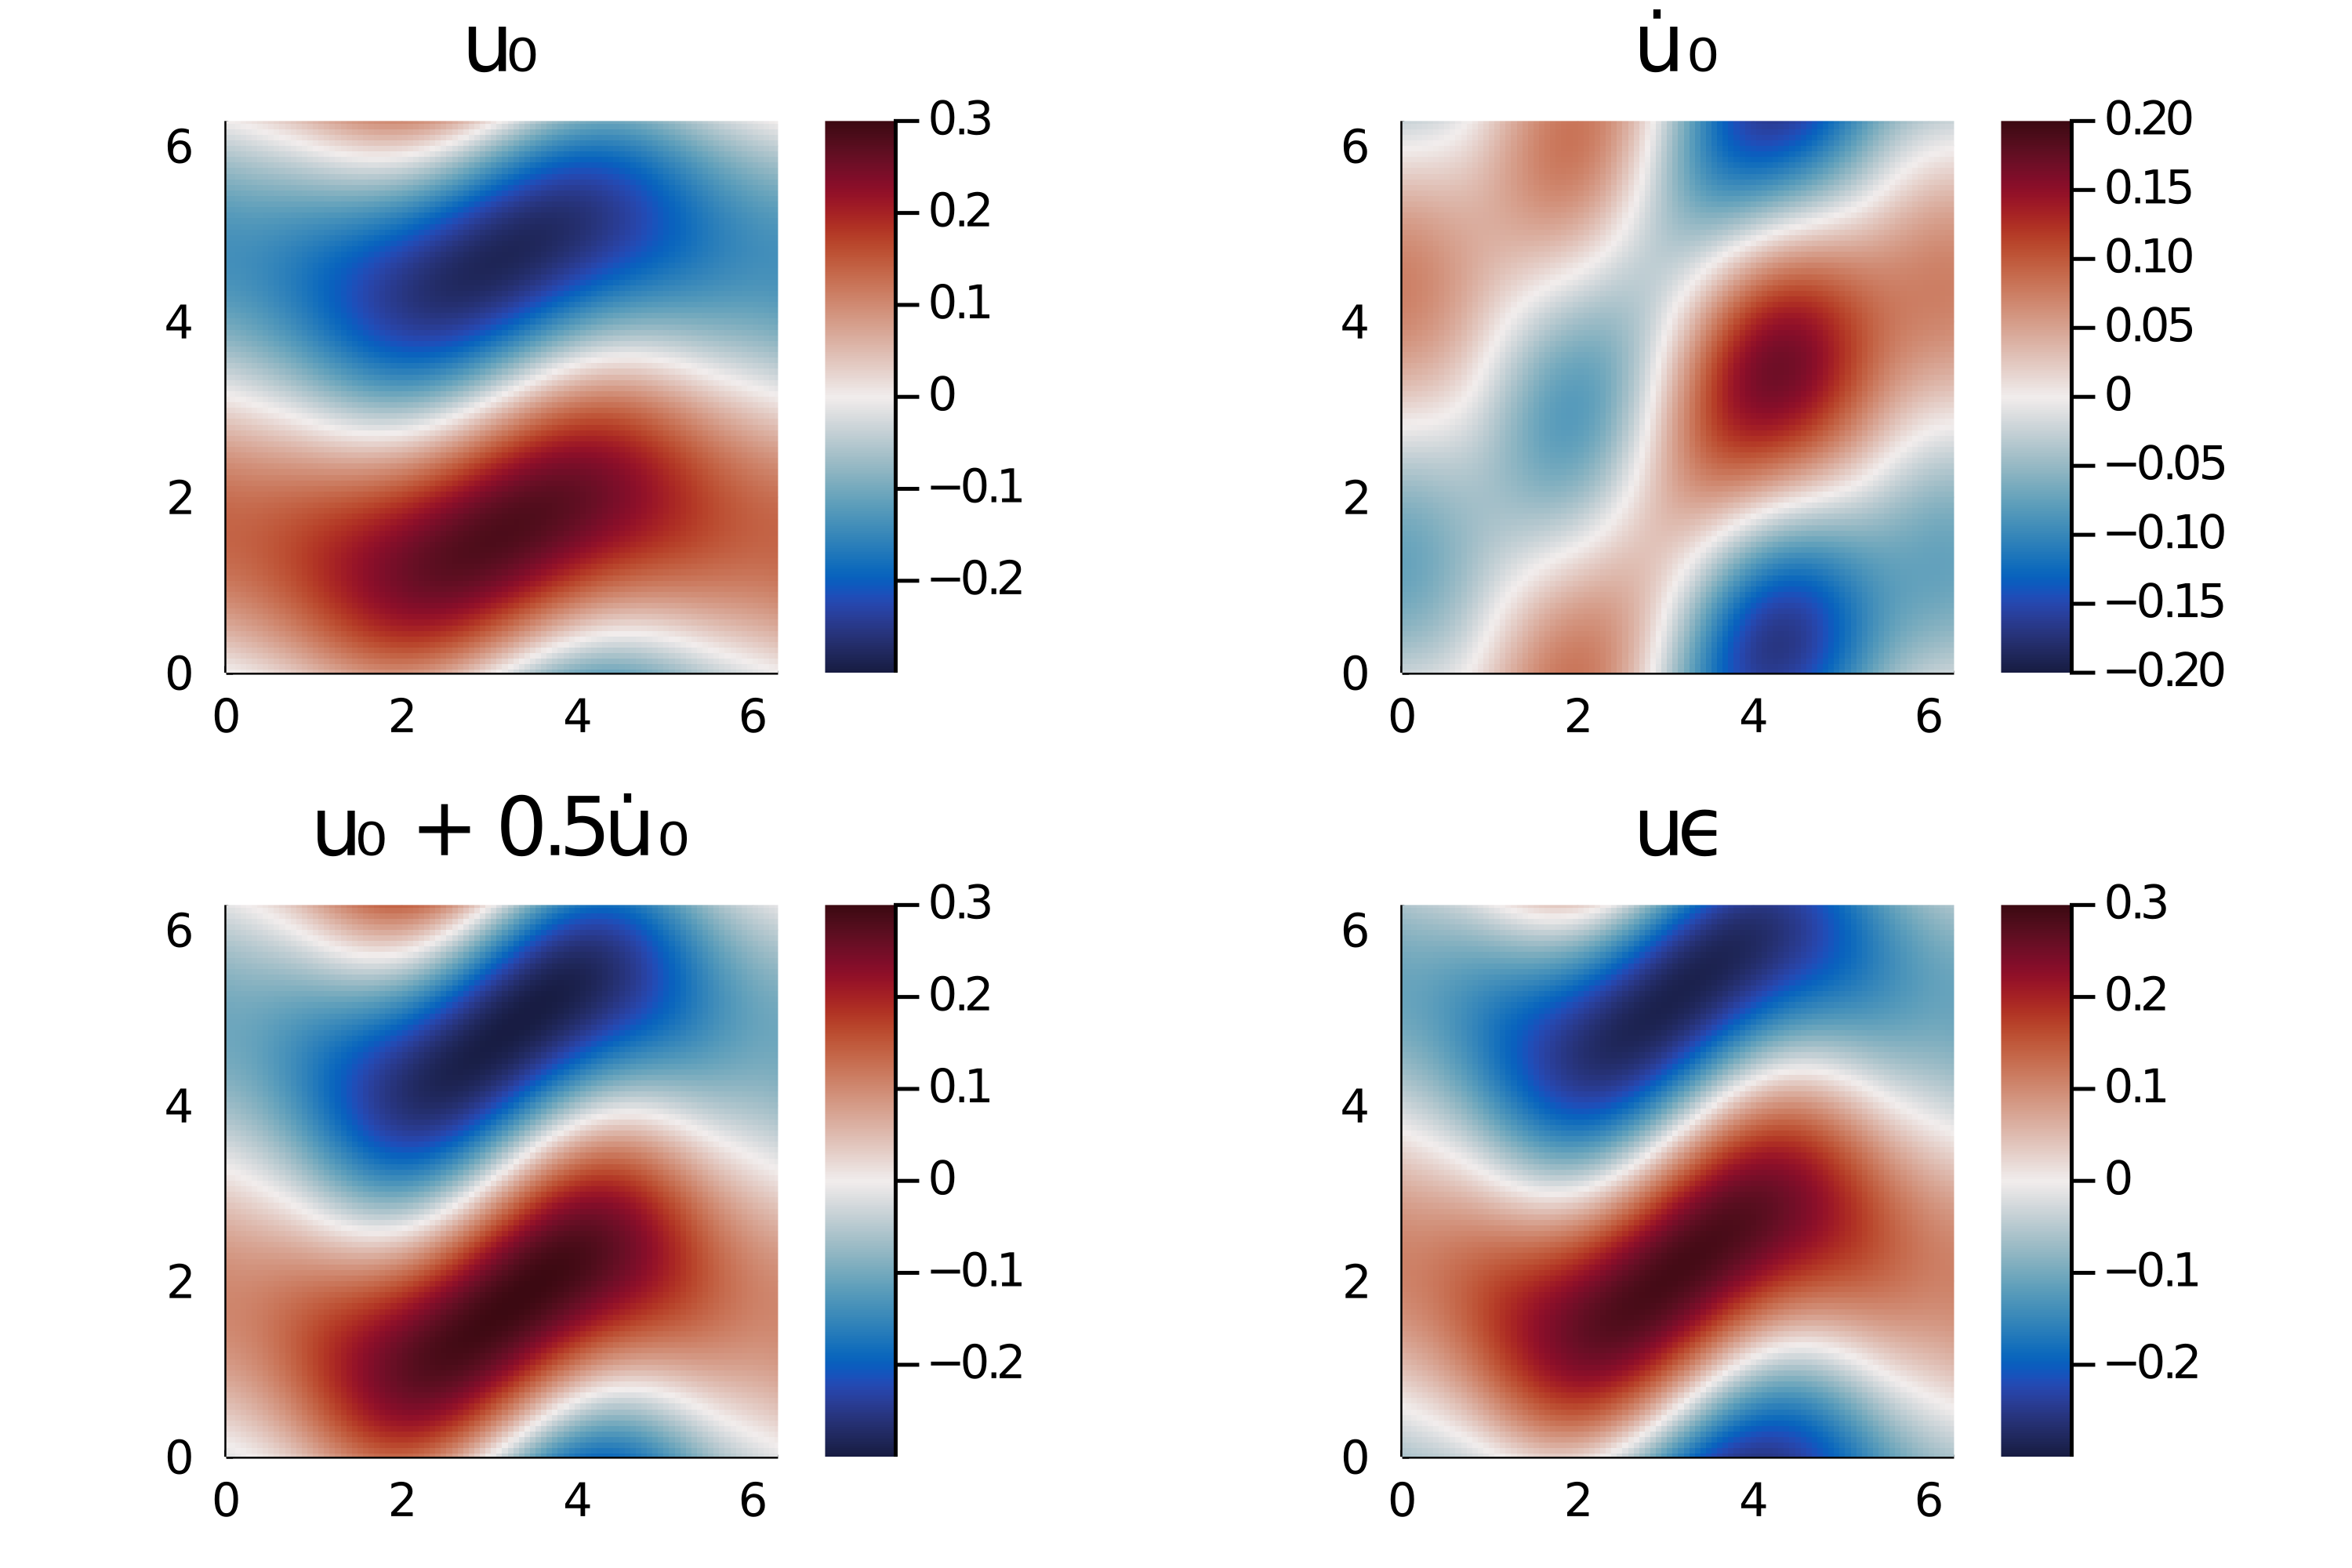

In [14]:
color =    :balance
xticks =   0:2:6
yticks =   0:2:6
colorbar = :left
cmin =     -0.3
cmax =     0.3
cmin_lr =  -0.2
cmax_lr =  0.2
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="u₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ", bdata=bdata,
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [15]:
using Contour
using StaticArrays

In [16]:
#Contour.jl needs StaticArrays
T_static(x) = SVector{2,Float64}(T(x,0))

T_static (generic function with 1 method)

In [17]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,T_static,tolerance=1e-10)
end

best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000,bdata=bdata)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.00028473028351544416
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0008542108637113466
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.001423691443907249
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0019931720241031514
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.002562652604299054
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0031321331844949563
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0037016137646908587
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.004271094344886761
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0048405749250826635
└ @ Main In[17]:15
┌ Warning: C

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05210746308134273
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05267694366153863
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.053246424241734536
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05381590482193044
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05438538540212634
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05495486598232224
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.055524346562518145
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05609382714271405
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.05666330772290995
└ @ Main In[17]:15
┌ Warning: Currently only 

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10506915703956182
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10563863761975772
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10620811819995363
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10677759878014953
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10734707936034543
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10791655994054133
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10848604052073724
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10905552110093314
└ @ Main In[17]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.10962500168112904
└ @ Main In[17]:15
┌ Warning: Currently only co

Dynamic Cheeger value:	1.7672371424421804
Levelset:		0.199033452771886


cheeger value		length			length transported	volume
2.0851512407303487	13.143764714172018	25.006050125947624	9.147973081021506
1.7672371424421804	9.312585414548549	8.181246757254481	4.949486334252785


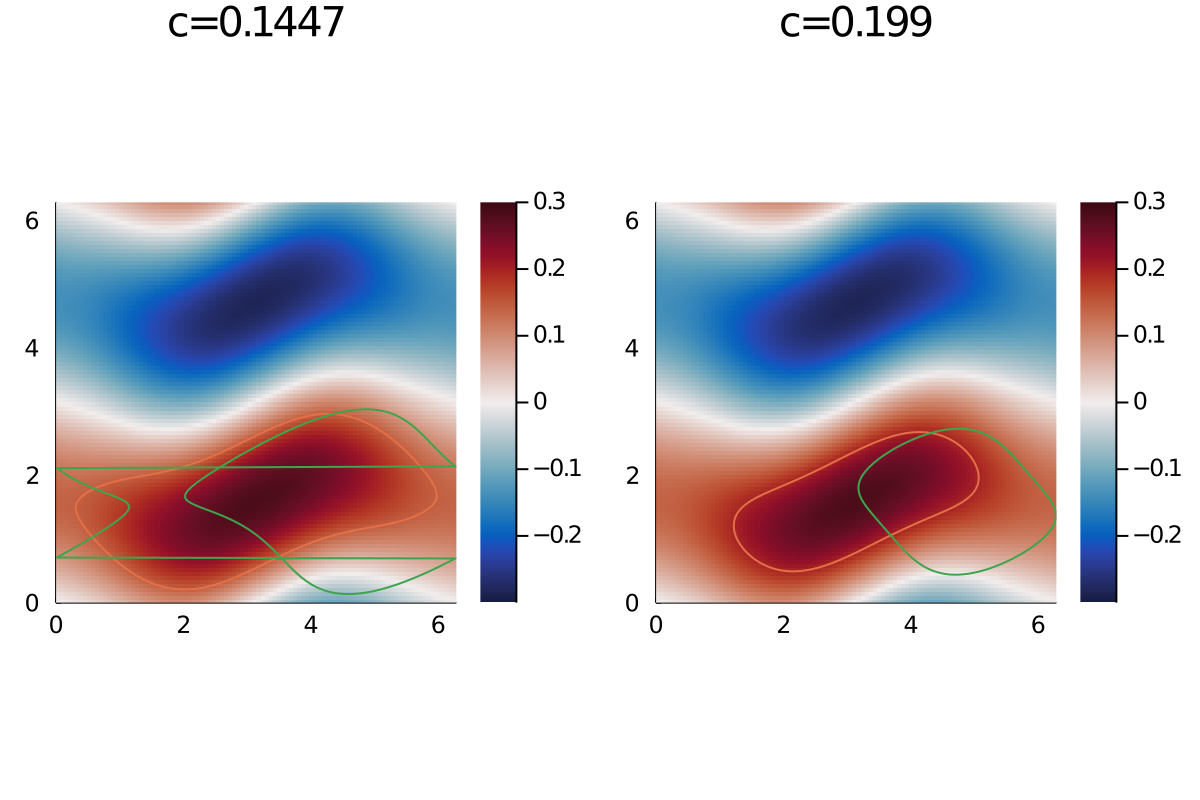

In [18]:
# value from paper
c_paper = 0.1447
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))[1]
curve_moved = Main.CoherentStructures.apply2curve(T_static,curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, T_static)
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",bdata=bdata,
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curve = lines(get_levelset(ctx, u₀, c_ours, bdata=bdata))[1]
curve = Main.CoherentStructures.closeCurve(ctx,curve)
curve_moved = Main.CoherentStructures.apply2curve(T_static,curve)

cheeger_value = dynamic_cheeger_value(ctx, curve, T_static)
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curve))\t",
    "$(Main.CoherentStructures.getLength(curve_moved))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curve))\n")

Plots.plot!(coordinates(curve))
Plots.plot!(coordinates(curve_moved))


Plots.plot(plot_paper, plot_ours, fmt=:png,dpi=200)

In [19]:
function plot_vectorfield(xs,ys,dx,dy;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    x_coords = repeat(xs, outer=length(ys))
    y_coords = repeat(ys, inner=length(xs))
    dx, dy = scale.*dx[1:step:end,1:step:end], scale.*dy[1:step:end,1:step:end]
    quiver(x_coords,y_coords,quiver=(vec(dx),vec(dy)))
end

plot_vectorfield (generic function with 1 method)

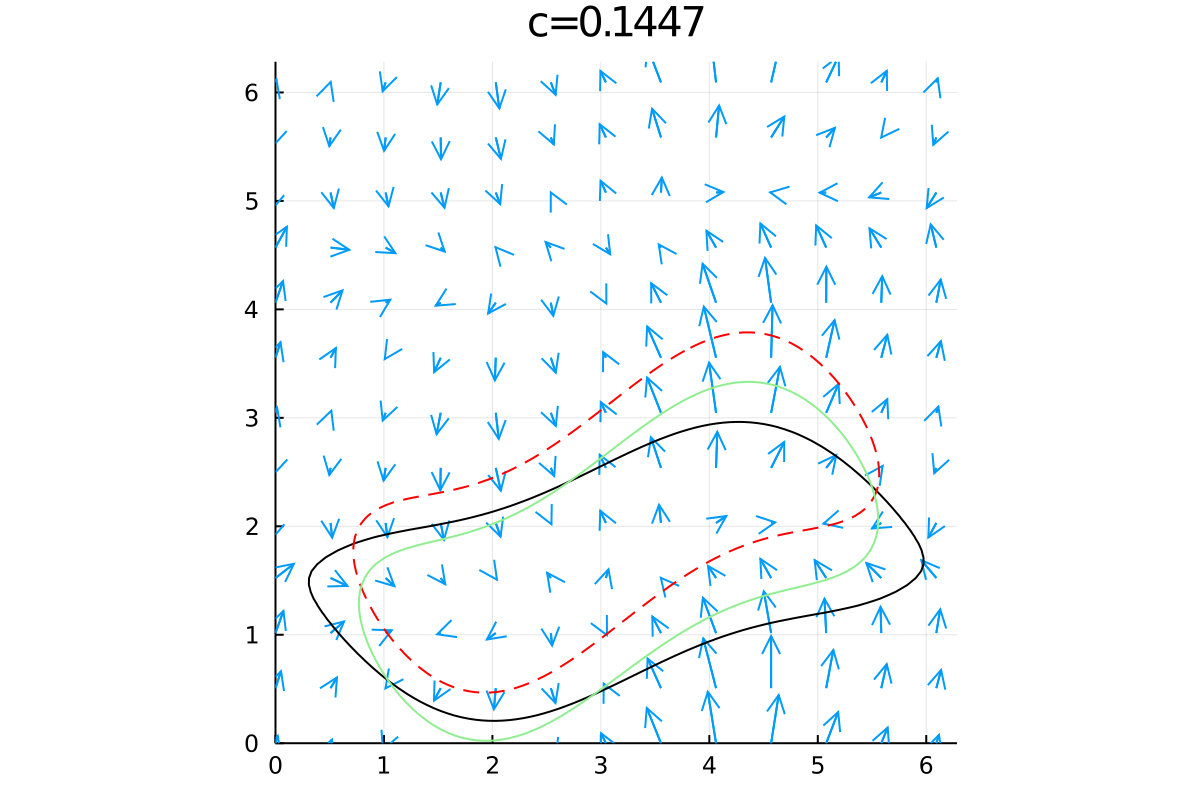

In [20]:
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot, bdata=bdata)...,scale=3,step=8)
curve         = lines(get_levelset(ctx, u₀, c_paper, bdata=bdata))[1]
curve_epsilon = lines(get_levelset(ctx, uϵ, c_paper, bdata=bdata))[1]
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper, bdata=bdata))


plot!(coordinates(curve),color=:black)
plot!(coordinates(curve_epsilon),color=:red,linestyle=:dash)
for c in curves_predicted
    plot!(coordinates(c),color=:lightgreen)
end

Plots.plot!(fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,2π),ylims=(0,2π),title="c=$(round(c_paper,digits=4))")